# MLP
MLP, K=5, droput, 150 epoch.

lncRNA. Baseline, nothing exluded.

Like MLP_265, which used GMM on H1.hESC only. Here, use -1.

In [13]:
from datetime import datetime
print(datetime.now())

2023-04-13 20:40:18.726675


In [14]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODEL_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [15]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
#from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=150 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
#EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
EXCLUSIONS = [0,2,3,4,5,6,7,8,9,10,11,12,13,14]   # use only H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = None # 'MLP_265'

Python 3.9.16
sklearn 1.2.2


In [16]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.all_cell_lines.csv'
RCI_FILE_TEST  = None #'test.lncRNA_RCI.all_cell_lines.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None #'test.canon_lncRNA_transcripts.csv'

In [17]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [18]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [19]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [20]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-13 20:40:19.641119
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 128)               131328    
                                                                 
 dense_45 (Dense)            (None, 64)                8256      
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_46 (Dense)            (None, 64)                4160      
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_47 (Dense)            (None, 1)                 65        
                                                                 
Total params: 143,809
Trai

## Training

In [21]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = -1 # or zero
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            filepath = MODEL_DIR + filename
            self.model.save(filepath)
            print('Saved model to',filepath)
        
    def load_model(self,filename):
        filepath = MODEL_DIR + filename
        self.model = keras.models.load_model(filepath)
        print('Loaded model from',filepath)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        #cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        #cwd = {0: cw[0], 1: cw[1]}
        #print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            )  # no validation # class_weight=cwd)
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            validation_data=(X_valid,y_valid) ) # class_weight=cwd, 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Extreme scores correct, pos:neg',correct_pos,correct_neg)  
        print('Extreme scores incorrect pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [22]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-13 20:40:19.863374
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 2982
Num RCI: 2982
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 2982 sequences.

Training # 1 1
2023-04-13 20:40:25.078774
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-13 20:40:25.087900
Discriminator ZERO -1
Train 1:0 1554:825 65.32%
Valid 1:0 385:218 63.85%
FIT
2023-04-13 20:40:25.174177


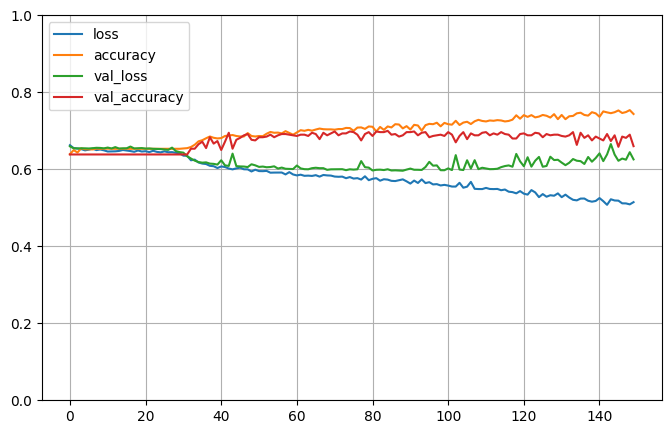


Testing # 1 1
2023-04-13 20:41:48.397616
2023-04-13 20:41:48.398056
PREDICT
2023-04-13 20:41:48.405015
Test 1:0 385:218 63.85%
Predict 1:0 428:175 70.98%
Test sizes (603, 1025) (603,)
Distrib of scores: 0.627198 mean 0.23212527 std
Range of scores: 0.020121694 to 0.969669
Score threshold 0.5
Confusion matrix
 [[ 94 124]
 [ 81 304]]
Normalized matrix
 [[0.15588723 0.20563847]
 [0.13432836 0.50414594]]
Extreme scores correct, pos:neg 258 58
Extreme scores incorrect pos:neg 81 32


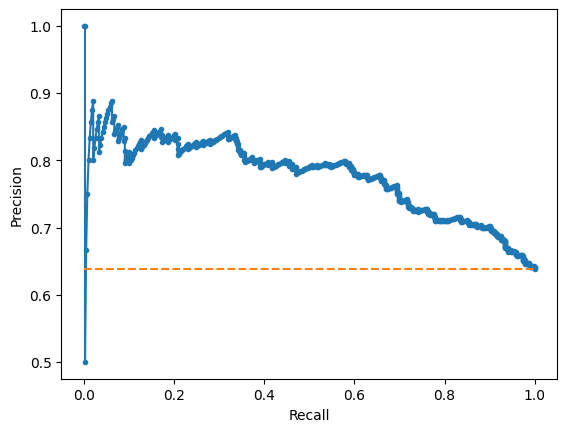

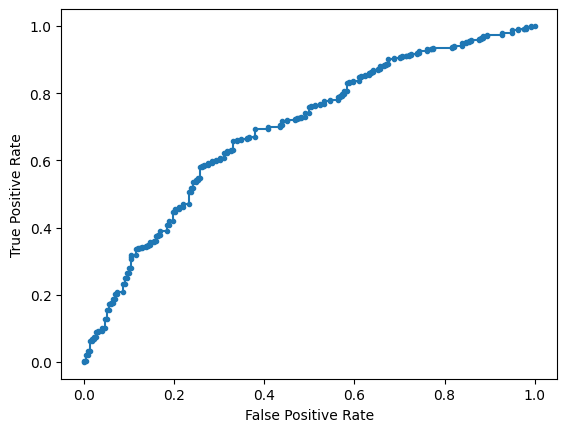

Accuracy: 66.00% Precision: 71.03% Recall: 78.96%
F1: 74.78% MCC: 0.2337
AUPRC: 77.58% AUROC: 69.19%
 accuracy [66.00331674958541]
 precision [71.02803738317756]
 recall [78.96103896103897]
 F1 [74.78474784747849]
 MCC [0.2337344734519301]
 AUPRC [77.57761387928015]
 AUROC [69.1850351483379]

Training # 1 2
2023-04-13 20:41:48.997262
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-13 20:41:49.020509
Discriminator ZERO -1
Train 1:0 1550:839 64.88%
Valid 1:0 389:204 65.60%
FIT
2023-04-13 20:41:49.109756


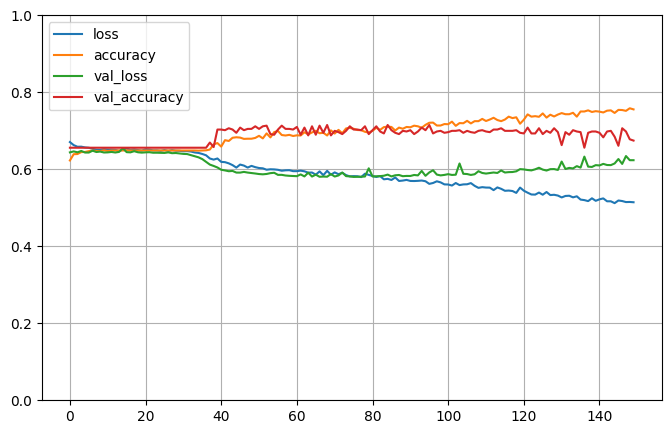


Testing # 1 2
2023-04-13 20:42:54.500444
2023-04-13 20:42:54.500494
PREDICT
2023-04-13 20:42:54.510669
Test 1:0 389:204 65.60%
Predict 1:0 416:177 70.15%
Test sizes (593, 1025) (593,)
Distrib of scores: 0.60957354 mean 0.2254904 std
Range of scores: 0.045083266 to 0.9934892
Score threshold 0.5
Confusion matrix
 [[ 94 110]
 [ 83 306]]
Normalized matrix
 [[0.15851602 0.18549747]
 [0.13996627 0.51602024]]
Extreme scores correct, pos:neg 232 59
Extreme scores incorrect pos:neg 79 38


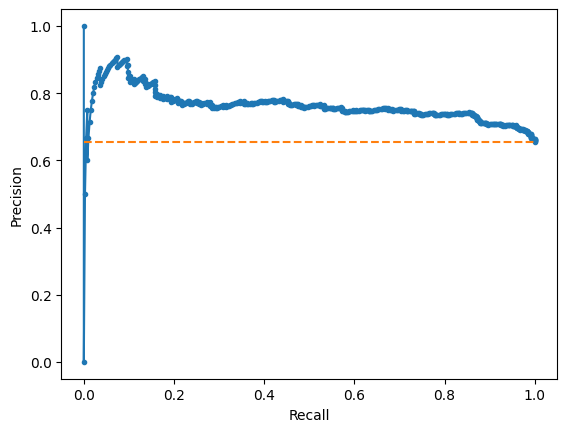

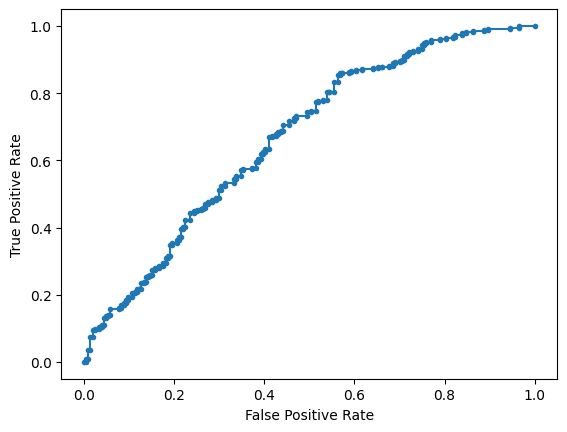

Accuracy: 67.45% Precision: 73.56% Recall: 78.66%
F1: 76.02% MCC: 0.2569
AUPRC: 76.23% AUROC: 66.77%
 accuracy [67.45362563237775]
 precision [73.5576923076923]
 recall [78.66323907455013]
 F1 [76.0248447204969]
 MCC [0.25685356848613233]
 AUPRC [76.22805992115707]
 AUROC [66.77251877614798]

Training # 1 3
2023-04-13 20:42:55.114550
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-13 20:42:55.137049
Discriminator ZERO -1
Train 1:0 1570:830 65.42%
Valid 1:0 369:213 63.40%
FIT
2023-04-13 20:42:55.220550


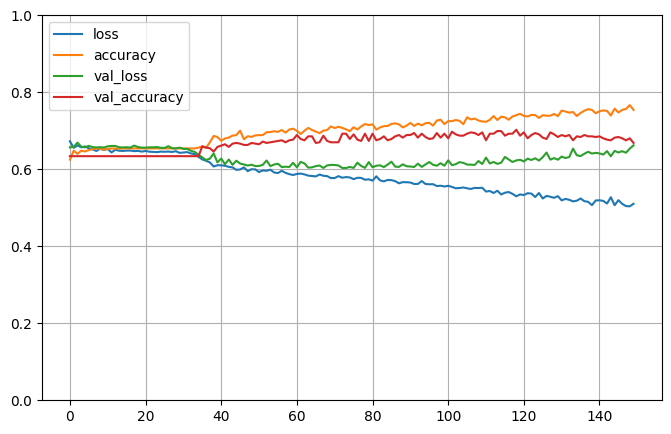


Testing # 1 3
2023-04-13 20:44:18.351464
2023-04-13 20:44:18.351516
PREDICT
2023-04-13 20:44:18.361981
Test 1:0 369:213 63.40%
Predict 1:0 492:90 84.54%
Test sizes (582, 1025) (582,)
Distrib of scores: 0.71804273 mean 0.20922914 std
Range of scores: 0.026020993 to 0.9741627
Score threshold 0.5
Confusion matrix
 [[ 55 158]
 [ 35 334]]
Normalized matrix
 [[0.09450172 0.27147766]
 [0.06013746 0.57388316]]
Extreme scores correct, pos:neg 297 34
Extreme scores incorrect pos:neg 120 20


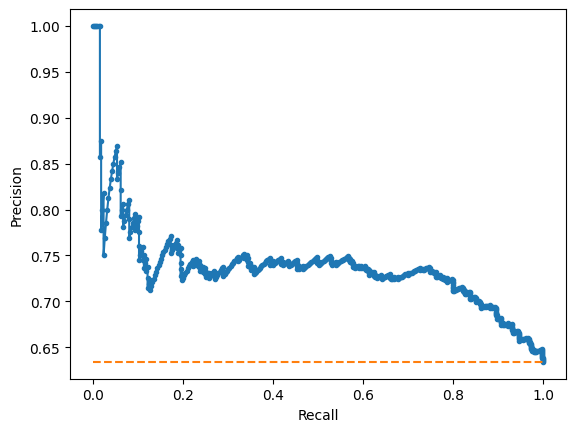

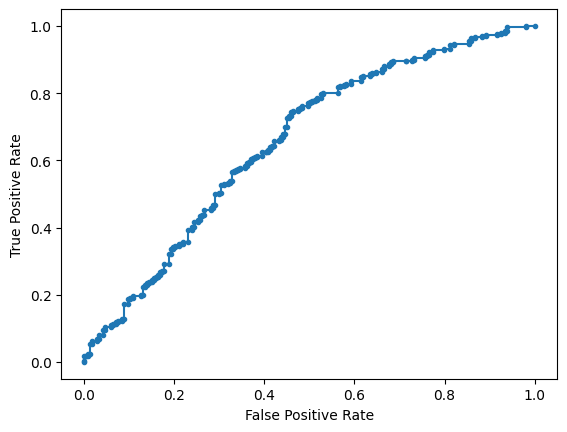

Accuracy: 66.84% Precision: 67.89% Recall: 90.51%
F1: 77.58% MCC: 0.2176
AUPRC: 73.68% AUROC: 65.48%
 accuracy [66.83848797250859]
 precision [67.88617886178862]
 recall [90.5149051490515]
 F1 [77.5842044134727]
 MCC [0.21764978016088285]
 AUPRC [73.68335991277966]
 AUROC [65.47832614476378]

Training # 1 4
2023-04-13 20:44:18.989786
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-13 20:44:19.011264
Discriminator ZERO -1
Train 1:0 1555:828 65.25%
Valid 1:0 384:215 64.11%
FIT
2023-04-13 20:44:19.096588


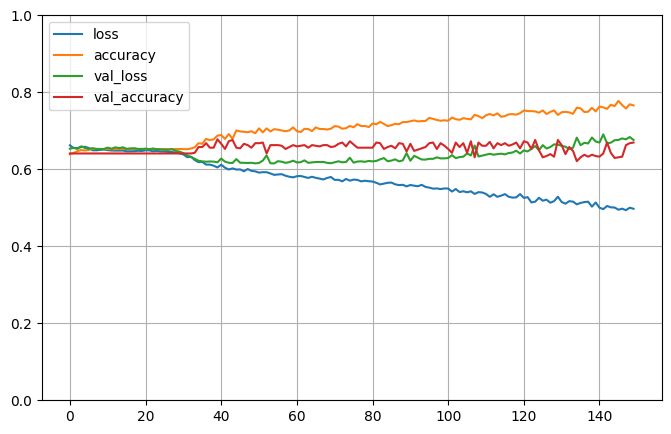


Testing # 1 4
2023-04-13 20:45:42.911011
2023-04-13 20:45:42.911070
PREDICT
2023-04-13 20:45:42.916933
Test 1:0 384:215 64.11%
Predict 1:0 458:141 76.46%
Test sizes (599, 1025) (599,)
Distrib of scores: 0.6637089 mean 0.234981 std
Range of scores: 0.014784879 to 0.9887836
Score threshold 0.5
Confusion matrix
 [[ 79 136]
 [ 62 322]]
Normalized matrix
 [[0.13188648 0.22704508]
 [0.10350584 0.5375626 ]]
Extreme scores correct, pos:neg 271 45
Extreme scores incorrect pos:neg 108 30


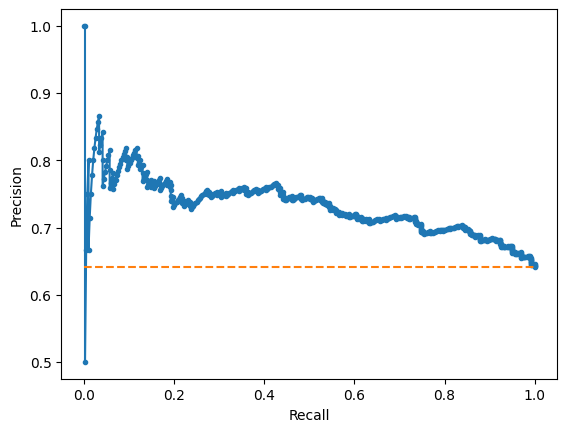

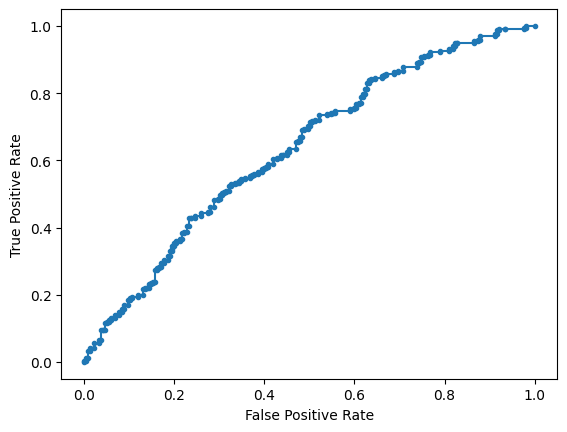

Accuracy: 66.94% Precision: 70.31% Recall: 83.85%
F1: 76.48% MCC: 0.2329
AUPRC: 73.18% AUROC: 63.46%
 accuracy [66.9449081803005]
 precision [70.3056768558952]
 recall [83.85416666666666]
 F1 [76.48456057007125]
 MCC [0.23290297565041967]
 AUPRC [73.18130426468208]
 AUROC [63.46293604651163]

Training # 1 5
2023-04-13 20:45:43.511745
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-13 20:45:43.538008
Discriminator ZERO -1
Train 1:0 1527:850 64.24%
Valid 1:0 412:193 68.10%
FIT
2023-04-13 20:45:43.618381


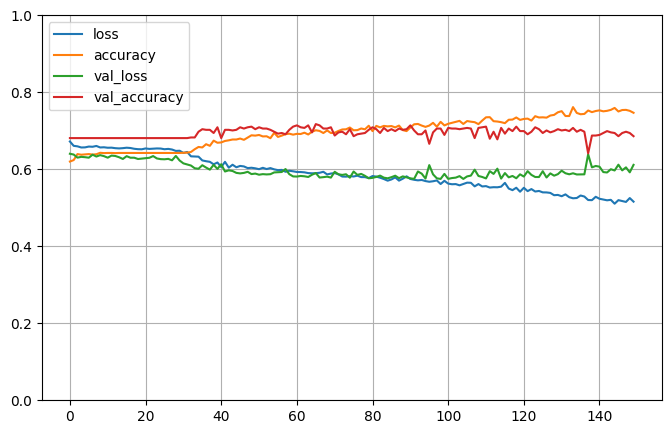


Testing # 1 5
2023-04-13 20:47:06.852611
2023-04-13 20:47:06.852660
PREDICT
2023-04-13 20:47:06.859809
Test 1:0 412:193 68.10%
Predict 1:0 438:167 72.40%
Test sizes (605, 1025) (605,)
Distrib of scores: 0.6168132 mean 0.23007432 std
Range of scores: 0.030938769 to 0.96899295
Score threshold 0.5
Confusion matrix
 [[ 85 108]
 [ 82 330]]
Normalized matrix
 [[0.14049587 0.1785124 ]
 [0.13553719 0.54545455]]
Extreme scores correct, pos:neg 252 59
Extreme scores incorrect pos:neg 67 50


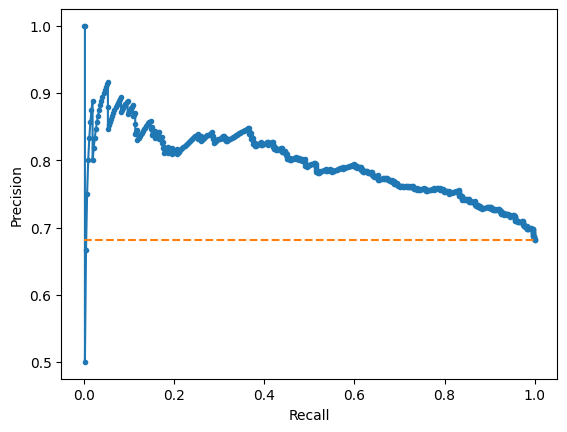

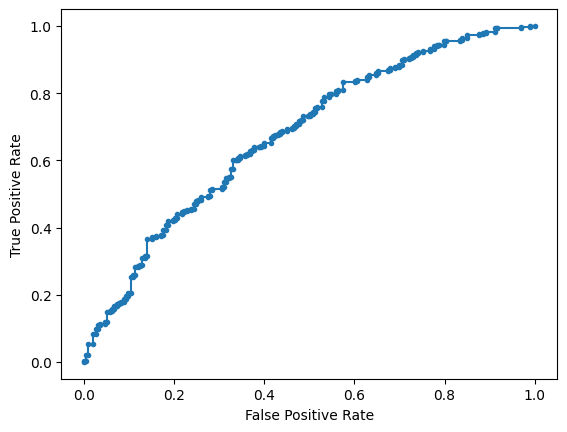

Accuracy: 68.60% Precision: 75.34% Recall: 80.10%
F1: 77.65% MCC: 0.2517
AUPRC: 79.53% AUROC: 67.60%
 accuracy [68.59504132231406]
 precision [75.34246575342466]
 recall [80.09708737864078]
 F1 [77.6470588235294]
 MCC [0.25167665729046995]
 AUPRC [79.52796745351267]
 AUROC [67.60400422556468]

Training # 2 1
2023-04-13 20:47:07.483144
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-13 20:47:07.508499
Discriminator ZERO -1
Train 1:0 1562:816 65.69%
Valid 1:0 377:227 62.42%
FIT
2023-04-13 20:47:07.587590


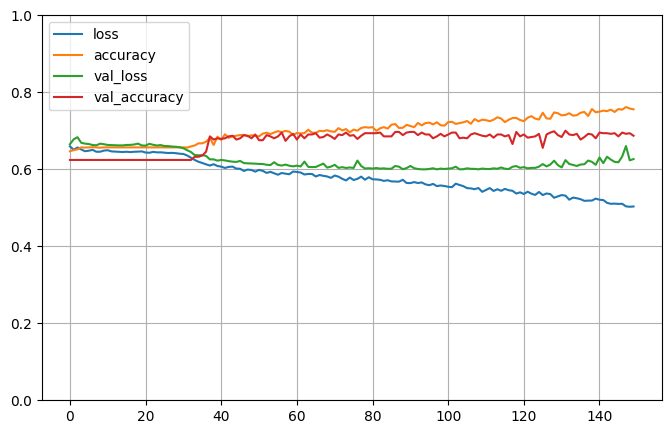


Testing # 2 1
2023-04-13 20:48:30.817247
2023-04-13 20:48:30.817299
PREDICT
2023-04-13 20:48:30.827773
Test 1:0 377:227 62.42%
Predict 1:0 464:140 76.82%
Test sizes (604, 1025) (604,)
Distrib of scores: 0.6636646 mean 0.22850704 std
Range of scores: 0.023816288 to 0.96407557
Score threshold 0.5
Confusion matrix
 [[ 89 138]
 [ 51 326]]
Normalized matrix
 [[0.14735099 0.22847682]
 [0.08443709 0.5397351 ]]
Extreme scores correct, pos:neg 262 54
Extreme scores incorrect pos:neg 99 18


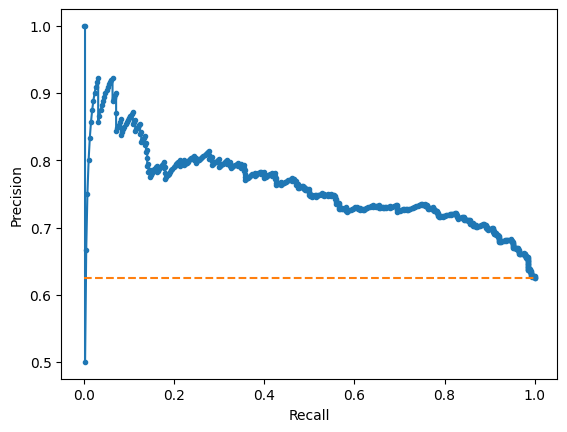

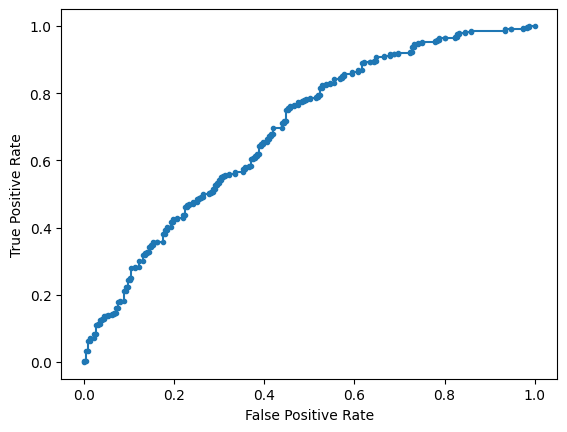

Accuracy: 68.71% Precision: 70.26% Recall: 86.47%
F1: 77.53% MCC: 0.2947
AUPRC: 76.09% AUROC: 68.92%
 accuracy [68.70860927152319]
 precision [70.25862068965517]
 recall [86.47214854111405]
 F1 [77.52675386444709]
 MCC [0.2947420057389461]
 AUPRC [76.09461033799056]
 AUROC [68.92461935755267]

Training # 2 2
2023-04-13 20:48:31.418400
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-13 20:48:31.442391
Discriminator ZERO -1
Train 1:0 1551:841 64.84%
Valid 1:0 388:202 65.76%
FIT
2023-04-13 20:48:31.555681


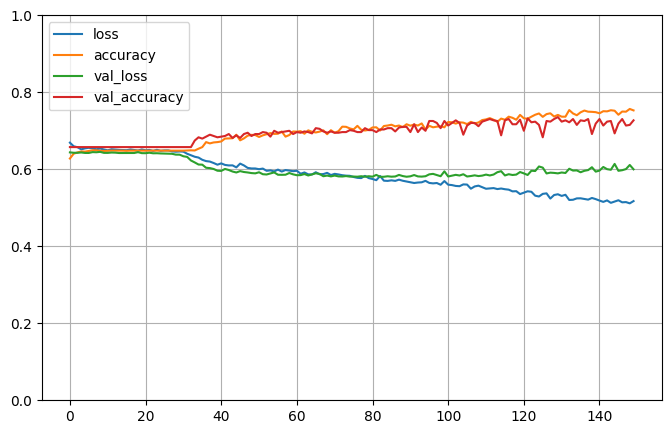


Testing # 2 2
2023-04-13 20:49:54.764795
2023-04-13 20:49:54.764844
PREDICT
2023-04-13 20:49:54.770015
Test 1:0 388:202 65.76%
Predict 1:0 451:139 76.44%
Test sizes (590, 1025) (590,)
Distrib of scores: 0.6494514 mean 0.22267169 std
Range of scores: 0.03665972 to 0.968324
Score threshold 0.5
Confusion matrix
 [[ 90 112]
 [ 49 339]]
Normalized matrix
 [[0.15254237 0.18983051]
 [0.08305085 0.57457627]]
Extreme scores correct, pos:neg 283 47
Extreme scores incorrect pos:neg 81 31


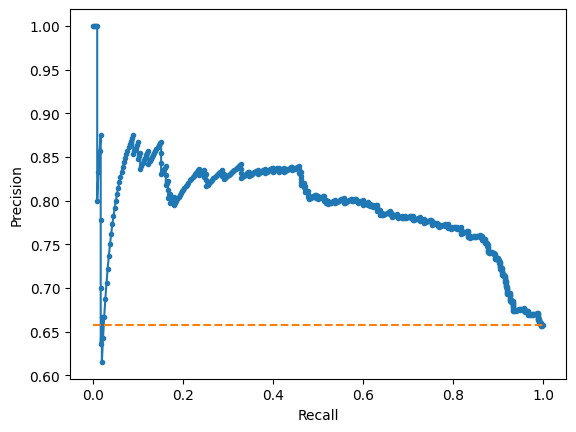

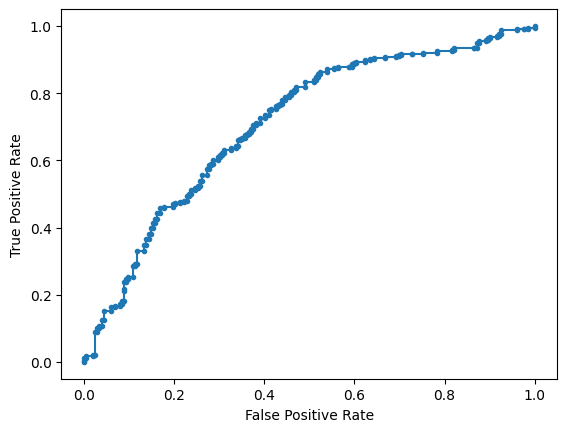

Accuracy: 72.71% Precision: 75.17% Recall: 87.37%
F1: 80.81% MCC: 0.3570
AUPRC: 79.39% AUROC: 70.97%
 accuracy [72.71186440677965]
 precision [75.16629711751663]
 recall [87.37113402061856]
 F1 [80.81048867699644]
 MCC [0.3569725332092494]
 AUPRC [79.39196654688774]
 AUROC [70.96815351638257]

Training # 2 3
2023-04-13 20:49:55.370656
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-13 20:49:55.394931
Discriminator ZERO -1
Train 1:0 1544:840 64.77%
Valid 1:0 395:203 66.05%
FIT
2023-04-13 20:49:55.478966


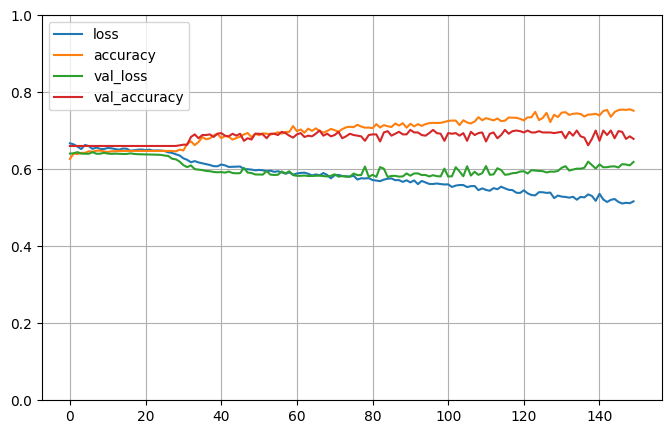


Testing # 2 3
2023-04-13 20:51:18.694679
2023-04-13 20:51:18.695098
PREDICT
2023-04-13 20:51:18.702204
Test 1:0 395:203 66.05%
Predict 1:0 425:173 71.07%
Test sizes (598, 1025) (598,)
Distrib of scores: 0.6085593 mean 0.23320666 std
Range of scores: 0.013227701 to 0.98737466
Score threshold 0.5
Confusion matrix
 [[ 92 111]
 [ 81 314]]
Normalized matrix
 [[0.15384615 0.18561873]
 [0.13545151 0.52508361]]
Extreme scores correct, pos:neg 246 62
Extreme scores incorrect pos:neg 66 39


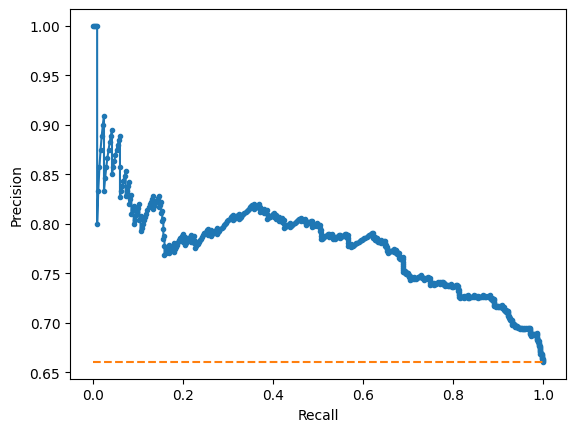

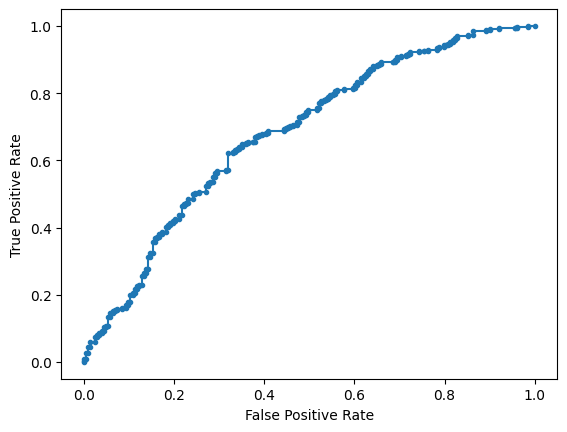

Accuracy: 67.89% Precision: 73.88% Recall: 79.49%
F1: 76.59% MCC: 0.2591
AUPRC: 77.94% AUROC: 68.04%
 accuracy [67.89297658862876]
 precision [73.88235294117646]
 recall [79.49367088607595]
 F1 [76.58536585365854]
 MCC [0.259133473557886]
 AUPRC [77.9353490319816]
 AUROC [68.03766290453328]

Training # 2 4
2023-04-13 20:51:19.287444
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-13 20:51:19.312255
Discriminator ZERO -1
Train 1:0 1559:842 64.93%
Valid 1:0 380:201 65.40%
FIT
2023-04-13 20:51:19.399420


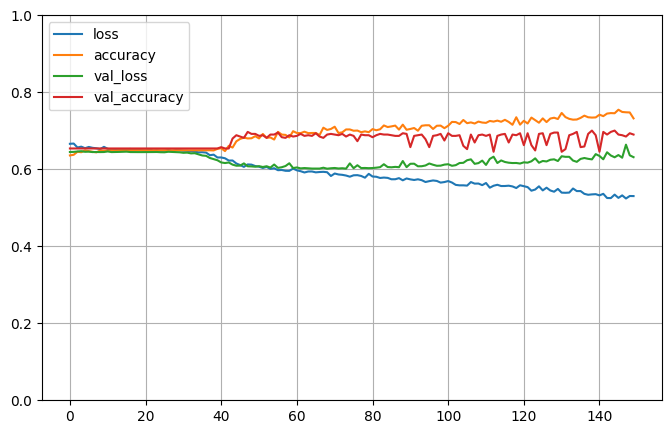


Testing # 2 4
2023-04-13 20:52:42.629814
2023-04-13 20:52:42.629869
PREDICT
2023-04-13 20:52:42.642294
Test 1:0 380:201 65.40%
Predict 1:0 476:105 81.93%
Test sizes (581, 1025) (581,)
Distrib of scores: 0.6901014 mean 0.19511959 std
Range of scores: 0.078860186 to 0.9815274
Score threshold 0.5
Confusion matrix
 [[ 63 138]
 [ 42 338]]
Normalized matrix
 [[0.10843373 0.23752151]
 [0.07228916 0.58175559]]
Extreme scores correct, pos:neg 274 31
Extreme scores incorrect pos:neg 108 12


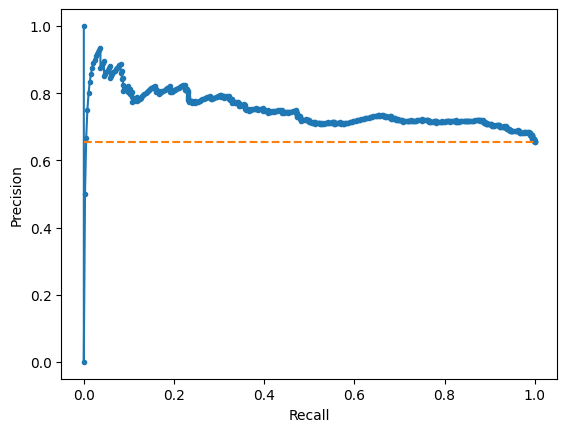

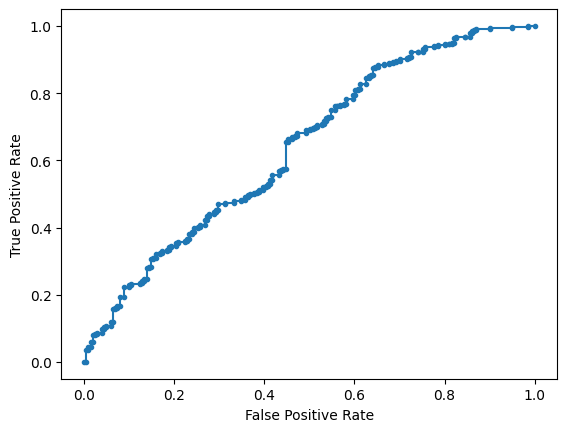

Accuracy: 69.02% Precision: 71.01% Recall: 88.95%
F1: 78.97% MCC: 0.2508
AUPRC: 74.99% AUROC: 63.98%
 accuracy [69.01893287435456]
 precision [71.00840336134453]
 recall [88.94736842105263]
 F1 [78.97196261682244]
 MCC [0.25083475073803196]
 AUPRC [74.98794382102008]
 AUROC [63.984027232259756]

Training # 2 5
2023-04-13 20:52:43.218066
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-13 20:52:43.241233
Discriminator ZERO -1
Train 1:0 1540:833 64.90%
Valid 1:0 399:210 65.52%
FIT
2023-04-13 20:52:43.317880


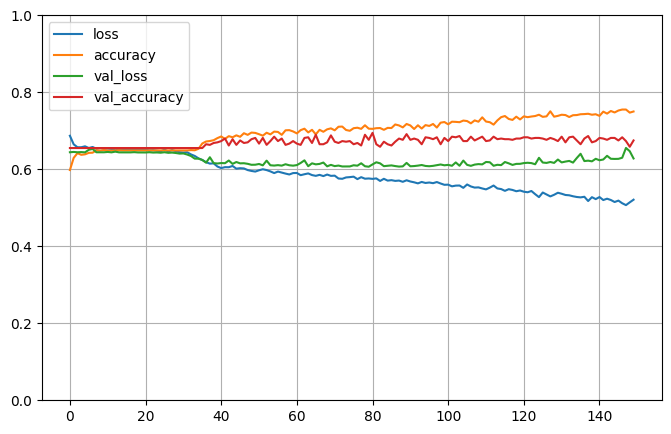


Testing # 2 5
2023-04-13 20:54:07.034493
2023-04-13 20:54:07.034541
PREDICT
2023-04-13 20:54:07.042569
Test 1:0 399:210 65.52%
Predict 1:0 499:110 81.94%
Test sizes (609, 1025) (609,)
Distrib of scores: 0.6886946 mean 0.20326453 std
Range of scores: 0.028022304 to 0.9666582
Score threshold 0.5
Confusion matrix
 [[ 61 149]
 [ 49 350]]
Normalized matrix
 [[0.1001642  0.24466338]
 [0.08045977 0.57471264]]
Extreme scores correct, pos:neg 297 33
Extreme scores incorrect pos:neg 106 20


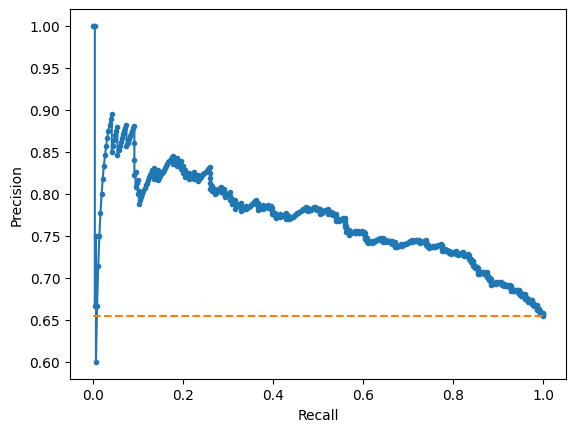

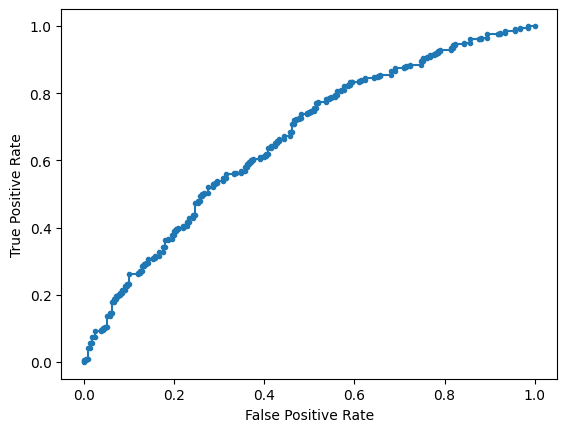

Accuracy: 67.49% Precision: 70.14% Recall: 87.72%
F1: 77.95% MCC: 0.2072
AUPRC: 76.90% AUROC: 66.32%
 accuracy [67.48768472906403]
 precision [70.14028056112225]
 recall [87.71929824561403]
 F1 [77.95100222717149]
 MCC [0.20715847338194757]
 AUPRC [76.90306805142613]
 AUROC [66.32414369256475]
2023-04-13 20:54:07.698106


In [23]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                cvdo.save_model(filename)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [24]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 68.17% std 1.85
 precision mean 71.86% std 2.48
 recall mean 84.21% std 4.56
 F1 mean 77.44% std 1.66
 MCC mean 0.2562 std 0.0430
 AUPRC mean 76.55% std 2.17
 AUROC mean 67.07% std 2.36
 accuracy [[66.00331674958541], [67.45362563237775], [66.83848797250859], [66.9449081803005], [68.59504132231406], [68.70860927152319], [72.71186440677965], [67.89297658862876], [69.01893287435456], [67.48768472906403]]
 precision [[71.02803738317756], [73.5576923076923], [67.88617886178862], [70.3056768558952], [75.34246575342466], [70.25862068965517], [75.16629711751663], [73.88235294117646], [71.00840336134453], [70.14028056112225]]
 recall [[78.96103896103897], [78.66323907455013], [90.5149051490515], [83.85416666666666], [80.09708737864078], [86.47214854111405], [87.37113402061856], [79.49367088607595], [88.94736842105263], [87.71929824561403]]
 F1 [[74.78474784747849], [76.0248447204969], [77.5842044134727], [76.48456057007125], [77.6470588235294], [77.52675386444709], [80.810488676